In [6]:
from __future__ import division
from math import *
import numpy as np
import scipy as sp
from scipy import stats, linalg
import pandas as pd
pd.options.display.mpl_style = 'default'

import matplotlib.pyplot as plt
#import seaborn

%matplotlib inline

from sklearn import tree

from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn import metrics

#import statsmodels.api as sm
#from statsmodels.graphics.api import qqplot

#import seaborn as sns
import random


# Identify 5 best ad groups

Performance of ads can be measured in 3 different levels:

1) click through rate, defined as (data.clicked)/(data.shown)

2) conversion cost, meaning the cost for each conversion, defined as (data.clicked)*(data.avg_cost_per_click)/(data.converted)

3) campaign profit, meaning cost of advertising subtracted from the revenue gain, defined as (data.total_revenue) - (data.avg_cost_per_click * data.clicked). Note that this is not the actual profit, since we are not considering the production cost.


** conversion cost (factor #2) and campaign profit (factor #3) are the most important one, from the perspective of the food delivery company, since they represents the time that campaign loses or gains money. Conversion cost may be tricky for quantitative analysis, due to possible division by zero, in campaigns without conversions. So for the performance comparisions we use factor #3, campaign profit here. **

In [7]:
data = pd.read_csv('datasets/ad_table.csv')
data.describe()

,shown,clicked,converted,avg_cost_per_click,total_revenue
count,2115.000000,2115.000000,2115.000000,2115.000000,2115.000000
mean,68299.844444,3056.077069,126.453901,1.373749,1966.517589
std,48884.821409,3783.579969,233.420826,0.754331,3942.018757
min,0.000000,0.000000,0.000000,0.000000,-200.150000
25%,28030.500000,744.000000,18.000000,0.760000,235.470000
50%,54029.000000,1392.000000,41.000000,1.400000,553.300000
75%,97314.500000,3366.500000,103.000000,1.920000,1611.495000
max,192507.000000,20848.000000,1578.000000,4.190000,39623.710000


In [11]:
data

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1
5,2015-10-06,66864,2617,46,0.98,746.48,ad_group_1
6,2015-10-07,68227,2390,42,0.94,462.33,ad_group_1
7,2015-10-08,68520,2909,46,1.07,441.28,ad_group_1
8,2015-10-09,67250,2385,49,0.88,602.14,ad_group_1
9,2015-10-10,67873,2614,42,0.93,490.55,ad_group_1


Looking at the min row, there are days that some ads are not shown, and data['shown']=0. These do not contain information on the performance, so just remove them.

In [3]:
data = data[data.shown>0]

In [8]:
inds = sp.random.randint(0, data.shape[0], 10)
#data['ad'] = data['ad'].map(lambda x: int(x[9:])) # make categorical to int

sdf = pd.pivot_table(data.iloc[inds,:], index=['date'], columns=['ad'], values=['clicked'],
                    aggfunc=[len,sum], fill_value=0).reset_index()
sdf

date         len                                                  \
                   clicked                                                   
ad             ad_group_10 ad_group_16 ad_group_26 ad_group_34 ad_group_38   
0   2015-10-01           0           0           0           0           1   
1   2015-10-09           1           0           0           0           0   
2   2015-10-10           1           0           0           0           0   
3   2015-10-15           0           1           0           0           0   
4   2015-10-25           0           0           1           0           0   
5   2015-10-29           0           0           0           1           0   
6   2015-11-03           0           0           0           0           0   
7   2015-11-05           0           0           0           0           0   
8   2015-11-07           0           1           0           0           0   

                                             sum                          \
                                         clicked                           
ad ad_group_40 ad_group_8 ad_group_9 ad_group_10 ad_group_16 ad_group_26   
0            0          0          0           0           0           0   
1            0          0          1        1451           0           0   
2            0          0          0        1916           0           0   
3            0          0          0           0        1016           0   
4            0          0          0           0           0        6641   
5            0          0          0           0           0           0   
6            0          1          0           0           0           0   
7            1          0          0           0           0           0   
8            0          0          0           0         879           0   

                                                              
                                                              
ad ad_group_34 ad_group_38 ad_group_40 ad_group_8 ad_group_9  
0            0       10977           0          0          0  
1            0           0           0          0        205  
2            0           0           0          0          0  
3            0           0           0          0          0  
4            0           0           0          0          0  
5         2825           0           0          0          0  
6            0           0           0       2770          0  
7            0           0        1499          0          0  
8            0           0           0          0          0

In [6]:
data['ctr'] = data['clicked'] / data['shown']
data['profit'] = data['total_revenue'] - (data['clicked'] * data['avg_cost_per_click'])
data.describe()

,shown,clicked,converted,avg_cost_per_click,total_revenue,ctr,profit
count,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000
mean,68722.250714,3074.977640,127.235966,1.382245,1978.679686,0.046534,-3724.825376
std,48738.790888,3787.599283,233.929171,0.748857,3951.150051,0.032601,7653.631832
min,7494.000000,0.000000,0.000000,0.000000,-200.150000,0.000000,-66160.260000
25%,28371.750000,751.000000,18.000000,0.770000,240.132500,0.013885,-4011.667500
50%,54439.500000,1404.500000,42.000000,1.410000,556.055000,0.041158,-1291.810000
75%,97742.250000,3392.250000,105.000000,1.920000,1618.670000,0.075079,-133.570000
max,192507.000000,20848.000000,1578.000000,4.190000,39623.710000,0.123993,16067.220000


In [7]:
data[data.clicked==0].shape[0]

7

There are 7 ads which did not get any click, they did not lose any money, but still their ctr shold be considered in performance evaluation, since this shows they are not displayed at the right place for the right market.

In [8]:
gb = data.groupby('ad')['profit'].aggregate([np.mean, np.var])
gb['num_ads'] = data.groupby(['ad']).size()
gb.rename(columns={'mean': 'mean_profit', 'var': 'var_profit'},inplace=True)    

hypothesis is that the ad groups with highest mean profit are the best performing ones. Let's do a t-test and compare each ad group with the whole population to see if the are really performing better, or it's just due to chance.  

In [9]:
t_stats = []
p_vals = []

for group in gb.index:
    dt = data['profit']
    tt,pval = stats.ttest_ind(np.array(dt[data.ad==group]) , np.array(dt))
    t_stats.append(tt)
    p_vals.append(pval)
    
gb['t_stat'] = t_stats
gb['p_val'] = p_vals


In [47]:
gb = gb.sort('t_stat',ascending=False)
gb.head(5)

,mean_profit,var_profit,num_ads,t_stat,p_val,ad
ad,,,,,,
ad_group_2,1027.480000,401264.145635,53,4.518972,0.000007,ad_group_2
ad_group_31,759.734528,66710.619906,53,4.264673,0.000021,ad_group_31
ad_group_16,630.971569,175956.823865,51,4.063228,0.000050,ad_group_16
ad_group_14,139.479808,14165.269590,52,3.640038,0.000279,ad_group_14
ad_group_27,47.711887,9873.201354,53,3.587606,0.000341,ad_group_27


(array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.]),
 <a list of 9 Text xticklabel objects>)

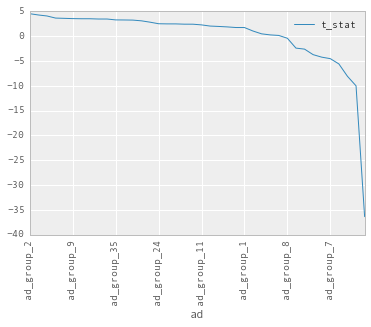

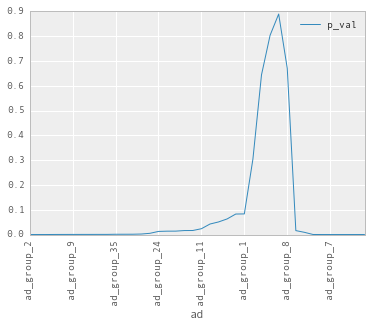

In [48]:
gb['ad'] = gb.index
gb.plot(x='ad',y='t_stat')
plt.xticks(rotation='vertical')

gb.plot(x='ad',y='p_val')
plt.xticks(rotation='vertical')

This provides evidence for rejecting the Null hypothesis and concluding that the top 5 performing ad groups are 2, 31, 16, 14, 27 respectively. The plots show the t-statistics and p-values for a confidence level of %95, when the groups are sorted based on the their mean profit. 

The top 5 values of t-statistics are the top-performing ones, providing evidence that large positive t-statistics means they are far in the positive tail of the t-distribution, meaning they are significantly better than the population mean, consisting of all ads for all days. Also p-valus are very small proving the significance. 

We can see that the p-values from ad_group_1 to ad_group_8 are not significant, since they are in the middle and perform like the population mean. t-statistics for worst performing ads in the left tail of distribution are large negarive numbers, along with their samall p-value, showing they are significantly worse than the average of all ads.

Here is the sorting of all campaigns based on their performance, from best to worst:

In [49]:
ad_groups_sorted = [str(item) for item in gb.index]
print ad_groups_sorted

['ad_group_2', 'ad_group_31', 'ad_group_16', 'ad_group_14', 'ad_group_27', 'ad_group_9', 'ad_group_15', 'ad_group_36', 'ad_group_21', 'ad_group_22', 'ad_group_35', 'ad_group_17', 'ad_group_33', 'ad_group_25', 'ad_group_40', 'ad_group_24', 'ad_group_23', 'ad_group_30', 'ad_group_34', 'ad_group_12', 'ad_group_11', 'ad_group_39', 'ad_group_10', 'ad_group_6', 'ad_group_29', 'ad_group_1', 'ad_group_28', 'ad_group_5', 'ad_group_19', 'ad_group_13', 'ad_group_8', 'ad_group_32', 'ad_group_37', 'ad_group_18', 'ad_group_20', 'ad_group_7', 'ad_group_26', 'ad_group_4', 'ad_group_38', 'ad_group_3']


# Predict number of ads shown

Here we first extract week-of-the-year and day-of-the-week to get an idea of seasonality and trends. 

In [19]:
data['date'] = pd.to_datetime(data['date'])
data['weekday'] = data['date'].map(lambda x:x.weekday())
data['weekofyear'] = data['date'].map(lambda x:x.weekofyear)

In order to predict the number of shown ads in a future date, we need to see if there is a trend on relationship of number of shown ads versus features like 'clicked','converted', 'avg_cost_per_click', 'total_revenue', 'ad', 'weekday','weekofyear'. To do so, we first need to build a predictive model on 'shown' and find the important features, and then do a time series prediction on those important feature for Dec 15th to finally predict the shown ads on Dec 15th.

In [27]:
#le = preprocessing.LabelEncoder()
#le.fit(np.unique(data['ad']))
#data['ad'] = data['ad'].map(lambda x:le.transform(x))

data['ad'] = data['ad'].map(lambda x: int(x[9:])) # make categorical to int

X = data[['clicked','converted','avg_cost_per_click','total_revenue','ad','weekday','weekofyear']]
Y = data['shown']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.30)

estimator = RandomForestRegressor(n_estimators=100, oob_score=True)
estimator.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

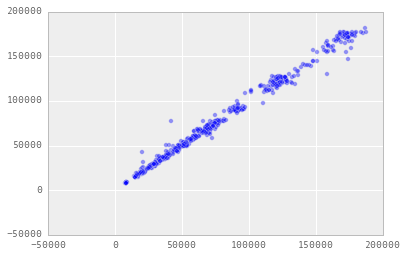

In [28]:
plt.scatter(Y_test, estimator.predict(X_test), alpha=0.4)

Looks it's predicting well. Now let's check for the test and train score to make sure we're not overfitting.

In [29]:
print 'test data score is:', estimator.score(X_test,Y_test)
print 'train data score is:', estimator.score(X_train,Y_train)

test data score is: 0.992587032468
train data score is: 0.997930565199


In [30]:
estimator.feature_importances_

array([  4.75481957e-01,   1.76809567e-01,   1.99362089e-01,
         8.74249768e-03,   1.36782968e-01,   4.29467843e-04,
         2.39145366e-03])

Seems that "weekday", "weekofyear", "total_revenue" do not matter much.So for the sake of simpler model, we remove them and retrain.

In [31]:
X = data[['clicked','converted','avg_cost_per_click','ad']]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.30)

estimator = RandomForestRegressor(n_estimators=100, oob_score=True)
estimator.fit(X_train, Y_train)

print 'test data score is:', estimator.score(X_test,Y_test)
print 'train data score is:', estimator.score(X_train,Y_train)
print 'feature importances are:', estimator.feature_importances_

test data score is: 0.989060416974
train data score is: 0.997859351993
feature importances are: [ 0.45166359  0.17287916  0.15825451  0.21720275]


The performance is on average the same, with removing those 3 parameters. The remaining parameters all contribute to the performance. By removing any of "clicked", "converted", "avg_cost_per_click" performance drops significantly. Removing the "ad" feature has a slight drops the performance on averagae ony by %0.1, compared to the other 3 factors.

Now that we found a reliable predictor on number of shown ads, let's predict the important factors on Dec 15, and then plug the results into the random forest predictor of "shown". Let's first check if there is a different trend in the number of ads shown based on ad group. Since "profit" was our chosen factor for performance of ads, let's see how profit and number of ads shown are related for each ad group. 

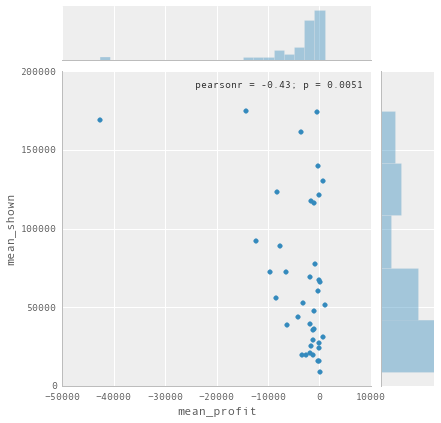

In [130]:
gb1 = data.groupby('ad')['shown'].aggregate([np.mean])
gb1.rename(columns={'mean': 'mean_shown'},inplace=True)
gb1['ad'] = gb1.index
gb1['mean_profit'] = data.groupby('ad')['profit'].aggregate(np.mean)
gb1 = gb1.sort('mean_shown',ascending=False)

sns.jointplot(gb1.loc[:,'mean_profit'], gb1.loc[:,'mean_shown'])

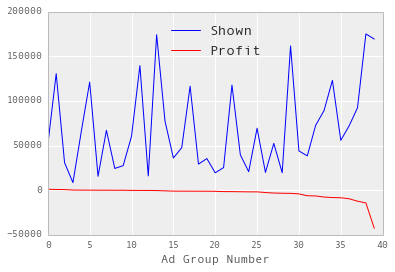

In [131]:
gb1 = gb1.sort('mean_profit',ascending=False)
plt.plot(gb1.loc[:,'mean_shown'],'b',label='Shown')
plt.plot(gb1.loc[:,'mean_profit'],'r',label='Profit')
plt.legend(loc=0 , fontsize='x-large')
plt.xlabel('Ad Group Number')

Number of shown ads are significantly positively correlated (r=0.31, p=0.04) with number of conversions, but very significantly negatively correlated (r=-0.43, p=0.005) with the profit, which is the best indicator of performance. It seems that the worst performing ads are shown the most.

This relationship between "profit" and "shown" is not necessary a correlation. In other words, it is not that since they are performing poorly, they are shown more in order to increase exposure. Actually one of the main reasons that they lose money is that they are shown more, therefor are clicked more (strong positive correlation; r=0.57, p=0.0001), and get conversions more (r=0.66, p=4e-6). The bottleneck is that the click cost, cancels out the revenue. either cost per click should be decrease, or the ads should be shown to market segments with potential interest; so minimizing the random clicks. 

Anyways, the above analysis suggests that the prediction on number of shown ads should be specific to the ad group, meaning separate models for each group.

The first model to use for the time series prediction could be an autoregressive integrated model. Integrated part is for de-treding.

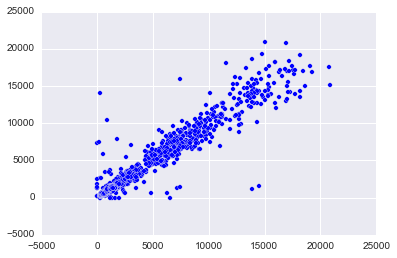

In [77]:
plt.scatter(np.append(np.array(data['clicked'][1:]),np.array([0]*1)),np.array(data['clicked']))

This indicates an AR(1) model

# Trend detection in avg_cost_per_click

Spearman's rank correlation is used here to detect monotonic trends in the average cost per click for each of the ad groups separately. This is a useful tool to assess monotonic relationship (either linear or not). 

In [42]:
rho = []
pval = []
ads = sorted([int(item) for item in np.unique(data.ad)])

for item in ads:
    cost = data[data.ad==str(item)].sort('date')['avg_cost_per_click'].reset_index(drop=True)
    r, p = stats.spearmanr(cost.index, cost)
    rho.append(r)
    pval.append(p)

The ones with positive spearman correlation rho show an increasing trend in avg_cost_per_click. Here I chose 0.1 as a threshod of closeness to zero. It's a crude estimate, but based on the range of correlations it seems ok.

In [75]:
np.where(np.array(rho)>0.1)

(array([ 0,  2,  8, 19, 30, 31, 36, 39]),)

The ad numbers with flat avg_cost_per_click:

In [74]:
np.where(abs(np.array(rho))<0.1)

(array([ 1,  3,  4,  9, 10, 11, 12, 14, 16, 17, 21, 22, 24, 25, 29, 33, 38]),)

The ad numbers with decreasing avg_cost_per_click:

In [76]:
np.where(np.array(rho)<-0.1)

(array([ 5,  6,  7, 13, 15, 18, 20, 23, 26, 27, 28, 32, 34, 35, 37]),)

In [132]:
import random

In [137]:
random.random()

0.811897842600791

In [139]:
1-0.05**(1/3)

0.6315968501359612